In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS, DBSCAN, cluster_optics_dbscan
from sklearn_extra.cluster import KMedoids
import random
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from sklearn.base import clone
import yfinance as yf
from utils.utils import Portfolio
from utils.helpers import pooled_within_ssd, gen_realizations, gap_statistic, cluster_range, plot_internal, plot_internal_zoom_range, generate_date_combinations
from utils.clusters import kmeans_cluster, kmedoids_cluster, agglomerative_cluster
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers = 6)
from tqdm import tqdm

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Load Data from YF for S&P500 and save it

In [3]:
sp500 = Portfolio('2013-01-01', '2024-01-01')
dji = Portfolio('2012-01-01','2024-01-01', file = 'data/dji.csv')
gspc = Portfolio('2012-01-01','2024-01-01', file = 'data/gspc.csv')

## Baselines for Sharpe Ratio: DJI & 30 Random

In [8]:
def create_port(row, ticker = None, file = 'data/sp500_data.csv'):
    buy_date = row['Buy']
    sell_date = row['Sell']
    port = Portfolio(buy_date, sell_date, file = file)
    
    if not ticker:
        tickers = port.prices.columns

    sharpe = port.get_portf_sharpe(tick = ticker)
    sortino = port.get_portf_sortino(tick = ticker)
    returns = port.get_portf_return(tick = ticker)
    volatility = port.get_portf_volatility(tick = ticker)

    return pd.Series([sharpe, sortino, returns, volatility])

def random_port(row, k = 30, trials = 100, file = 'data/sp500_data.csv'):
    
    results = pd.DataFrame(columns = ['Sharpe', 'Sortino', 'Return', 'Volatility'])
    
    buy_date = row['Buy']
    sell_date = row['Sell']
    port = Portfolio(buy_date, sell_date, file = file)

    for i in range(trials):
        ticker = random.sample(list(port.daily_log_returns.columns), k)
        sharpe = port.get_portf_sharpe(tick = ticker)
        sortino = port.get_portf_sortino(tick = ticker)
        returns = port.get_portf_return(tick = ticker)
        volatility = port.get_portf_volatility(tick = ticker)
        results.loc[i] = [sharpe, sortino, returns, volatility]

    return pd.Series(results.mean().tolist())

In [9]:
dates = generate_date_combinations(sp500.prices.index, 5, 1)
dates

,Start,End,Buy,Sell
0,2013-01-02,2018-01-02,2018-01-03,2019-01-03
1,2013-01-03,2018-01-03,2018-01-04,2019-01-04
2,2013-01-04,2018-01-04,2018-01-05,2019-01-07
3,2013-01-07,2018-01-08,2018-01-09,2019-01-09
4,2013-01-08,2018-01-08,2018-01-09,2019-01-09
...,...,...,...,...
1253,2017-12-21,2022-12-21,2022-12-22,2023-12-22
1254,2017-12-22,2022-12-22,2022-12-23,2023-12-26
1255,2017-12-26,2022-12-27,2022-12-28,2023-12-28
1256,2017-12-27,2022-12-27,2022-12-28,2023-12-28


In [10]:
baseline = dates.copy()
baseline[['DJI_Sharpe', 'DJI_Sortino', 'DJI_Return', 'DJI_Volatility']] = baseline.parallel_apply(create_port, args = (None, 'data/dji.csv',), axis = 1)
baseline[['SP500_Sharpe', 'SP500_Sortino', 'SP500_Return', 'SP500_Volatility']] = baseline.parallel_apply(create_port, args = (None, 'data/sp500_data.csv',), axis = 1)
baseline[['Random_Sharpe', 'Random_Sortino', 'Random_Return', 'Random_Volatility']] = baseline.parallel_apply(random_port, args = (30, 100, 'data/sp500_data.csv',), axis = 1)
baseline

,Start,End,Buy,Sell,DJI_Sharpe,DJI_Sortino,DJI_Return,DJI_Volatility,SP500_Sharpe,SP500_Sortino,SP500_Return,SP500_Volatility,Random_Sharpe,Random_Sortino,Random_Return,Random_Volatility
0,2013-01-02,2018-01-02,2018-01-03,2019-01-03,-0.032721,-0.040314,-0.089736,0.011448,-0.037119,-0.046407,-0.091616,0.010313,-0.031356,-0.039677,-0.081588,0.010883
1,2013-01-03,2018-01-03,2018-01-04,2019-01-04,-0.023208,-0.029039,-0.065482,0.011626,-0.025641,-0.032619,-0.065310,0.010494,-0.018592,-0.024271,-0.051378,0.011197
2,2013-01-04,2018-01-04,2018-01-05,2019-01-07,-0.024801,-0.031004,-0.069755,0.011616,-0.025046,-0.031877,-0.063873,0.010499,-0.016541,-0.021510,-0.044849,0.010998
3,2013-01-07,2018-01-08,2018-01-09,2019-01-09,-0.020949,-0.026218,-0.059351,0.011636,-0.021600,-0.027547,-0.055441,0.010520,-0.016851,-0.022070,-0.046167,0.011280
4,2013-01-08,2018-01-08,2018-01-09,2019-01-09,-0.020949,-0.026218,-0.059351,0.011636,-0.021600,-0.027547,-0.055441,0.010520,-0.015249,-0.019758,-0.041628,0.011155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2017-12-21,2022-12-21,2022-12-22,2023-12-22,0.068261,0.111013,0.131965,0.007235,0.093912,0.148309,0.225079,0.008612,0.078554,0.126114,0.209897,0.009467
1254,2017-12-22,2022-12-22,2022-12-23,2023-12-26,0.067694,0.110051,0.130750,0.007232,0.093920,0.148322,0.225101,0.008612,0.079535,0.128253,0.215125,0.009497
1255,2017-12-26,2022-12-27,2022-12-28,2023-12-28,0.075951,0.123101,0.147051,0.007197,0.100681,0.158315,0.242006,0.008576,0.086220,0.138289,0.227030,0.009310
1256,2017-12-27,2022-12-27,2022-12-28,2023-12-28,0.075951,0.123101,0.147051,0.007197,0.100681,0.158315,0.242006,0.008576,0.084568,0.135029,0.222632,0.009331


In [11]:
baseline.to_csv('data/baseline_new_5-1.csv', index = False)

### 5:1 Method

In [25]:
dates = generate_date_combinations(sp500.prices.index, 5, 1)
dates

,Start,End,Buy,Sell
0,2013-01-02,2018-01-02,2018-01-03,2019-01-03
1,2013-01-03,2018-01-03,2018-01-04,2019-01-04
2,2013-01-04,2018-01-04,2018-01-05,2019-01-07
3,2013-01-07,2018-01-08,2018-01-09,2019-01-09
4,2013-01-08,2018-01-08,2018-01-09,2019-01-09
...,...,...,...,...
1253,2017-12-21,2022-12-21,2022-12-22,2023-12-22
1254,2017-12-22,2022-12-22,2022-12-23,2023-12-26
1255,2017-12-26,2022-12-27,2022-12-28,2023-12-28
1256,2017-12-27,2022-12-27,2022-12-28,2023-12-28


In [85]:
results_kmeans = dates.copy()
results_kmeans[['DJI_Sharpe', 'DJI_Sortino', 'DJI_Return']] = results_kmeans.parallel_apply(create_port, args = (None, 'data/dji.csv',), axis = 1)
results_kmeans[['SP500_Sharpe', 'SP500_Sortino', 'SP500_Return']] = results_kmeans.parallel_apply(create_port, args = (None, 'data/sp500_data.csv',), axis = 1)
results_kmeans[['Random_Sharpe', 'Random_Sortino', 'Random_Return']] = results_kmeans.parallel_apply(random_port, args = (30, 100, 'data/sp500_data.csv',), axis = 1)
results_kmeans

,Start,End,Buy,Sell,DJI_Sharpe,DJI_Sortino,DJI_Return,SP500_Sharpe,SP500_Sortino,SP500_Return,Random_Sharpe,Random_Sortino,Random_Return
0,2013-01-02,2018-01-02,2018-01-03,2019-01-03,-0.032721,-0.040314,-0.089736,-0.037119,-0.046407,-0.091616,-0.028551,-0.036491,-0.075246
1,2013-01-03,2018-01-03,2018-01-04,2019-01-04,-0.023208,-0.029039,-0.065482,-0.025641,-0.032619,-0.065310,-0.020965,-0.026933,-0.057112
2,2013-01-04,2018-01-04,2018-01-05,2019-01-07,-0.024801,-0.031004,-0.069755,-0.025046,-0.031877,-0.063873,-0.021065,-0.027641,-0.058040
3,2013-01-07,2018-01-08,2018-01-09,2019-01-09,-0.020949,-0.026218,-0.059351,-0.021600,-0.027547,-0.055441,-0.015502,-0.020265,-0.042925
4,2013-01-08,2018-01-08,2018-01-09,2019-01-09,-0.020949,-0.026218,-0.059351,-0.021600,-0.027547,-0.055441,-0.018152,-0.023729,-0.049600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2017-12-21,2022-12-21,2022-12-22,2023-12-22,0.068261,0.111013,0.131965,0.093912,0.148309,0.225079,0.084625,0.137498,0.223036
1254,2017-12-22,2022-12-22,2022-12-23,2023-12-26,0.067694,0.110051,0.130750,0.093920,0.148322,0.225101,0.080037,0.129678,0.217860
1255,2017-12-26,2022-12-27,2022-12-28,2023-12-28,0.075951,0.123101,0.147051,0.100681,0.158315,0.242006,0.086422,0.138803,0.231924
1256,2017-12-27,2022-12-27,2022-12-28,2023-12-28,0.075951,0.123101,0.147051,0.100681,0.158315,0.242006,0.088256,0.140653,0.230276


In [86]:
results_kmeans.to_csv('data/baseline_5-1.csv')

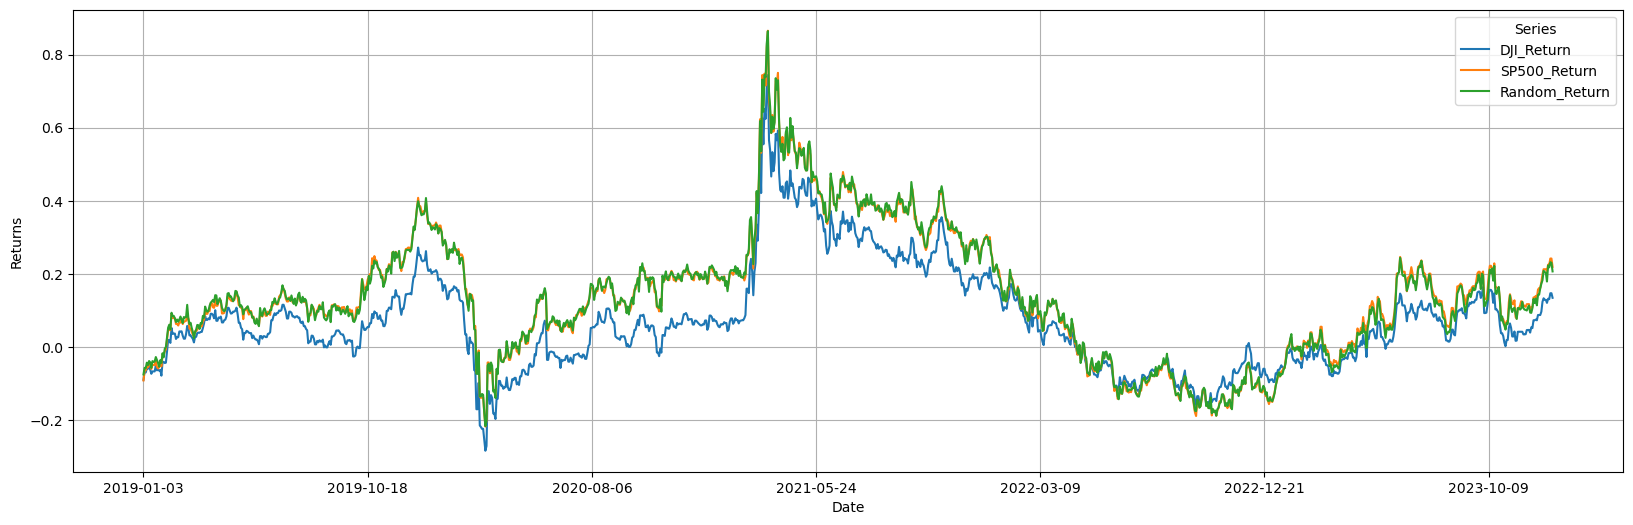

In [326]:
results_kmeans = pd.read_csv('data/baseline_5-1.csv')[['Sell', 'DJI_Return', 'SP500_Return', 'Random_Return']]
results_kmeans.set_index('Sell', inplace=True)

# Create a figure and axis, specifying the size
fig, ax = plt.subplots(figsize=(20, 6))

# Plot the data on the specified axis
results_kmeans.plot(ax=ax)

# Customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
ax.legend(title='Series')
ax.grid(True)

# Show the plot
plt.show()

### 3:1 Method

In [306]:
dates = generate_date_combinations(sp500.prices.index, 3, 1)
dates

,Start,End,Buy,Sell
0,2013-01-02,2016-01-04,2016-01-05,2017-01-05
1,2013-01-03,2016-01-04,2016-01-05,2017-01-05
2,2013-01-04,2016-01-04,2016-01-05,2017-01-05
3,2013-01-07,2016-01-07,2016-01-08,2017-01-09
4,2013-01-08,2016-01-08,2016-01-11,2017-01-11
...,...,...,...,...
1755,2019-12-20,2022-12-20,2022-12-21,2023-12-21
1756,2019-12-23,2022-12-23,2022-12-27,2023-12-27
1757,2019-12-24,2022-12-27,2022-12-28,2023-12-28
1758,2019-12-26,2022-12-27,2022-12-28,2023-12-28


In [308]:
results_kmeans = dates.copy()
results_kmeans[['DJI_Sharpe', 'DJI_Sortino', 'DJI_Return']] = results_kmeans.parallel_apply(create_port, args = (None, 'data/dji.csv',), axis = 1)
results_kmeans[['SP500_Sharpe', 'SP500_Sortino', 'SP500_Return']] = results_kmeans.parallel_apply(create_port, args = (None, 'data/sp500_data.csv',), axis = 1)
results_kmeans[['Random_Sharpe', 'Random_Sortino', 'Random_Return']] = results_kmeans.parallel_apply(random_port, args = (30, 100, 'data/sp500_data.csv',), axis = 1)
results_kmeans

,Start,End,Buy,Sell,DJI_Sharpe,DJI_Sortino,DJI_Return,SP500_Sharpe,SP500_Sortino,SP500_Return,Random_Sharpe,Random_Sortino,Random_Return
0,2013-01-02,2016-01-04,2016-01-05,2017-01-05,0.074345,0.096797,0.159723,0.066848,0.086858,0.157552,0.061972,0.082904,0.158478
1,2013-01-03,2016-01-04,2016-01-05,2017-01-05,0.074345,0.096797,0.159723,0.066848,0.086858,0.157552,0.065915,0.088658,0.164822
2,2013-01-04,2016-01-04,2016-01-05,2017-01-05,0.074345,0.096797,0.159723,0.066848,0.086858,0.157552,0.065837,0.087542,0.166066
3,2013-01-07,2016-01-07,2016-01-08,2017-01-09,0.101586,0.134732,0.216618,0.090393,0.117972,0.212879,0.088486,0.119736,0.218782
4,2013-01-08,2016-01-08,2016-01-11,2017-01-11,0.101416,0.134687,0.216830,0.093167,0.121049,0.220557,0.091148,0.122891,0.226952
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755,2019-12-20,2022-12-20,2022-12-21,2023-12-21,0.062459,0.102200,0.120680,0.086849,0.137748,0.207407,0.073888,0.119044,0.200655
1756,2019-12-23,2022-12-23,2022-12-27,2023-12-27,0.068684,0.111685,0.132814,0.094707,0.149568,0.227193,0.081574,0.132275,0.220776
1757,2019-12-24,2022-12-27,2022-12-28,2023-12-28,0.075951,0.123101,0.147051,0.100681,0.158315,0.242006,0.086819,0.140145,0.239303
1758,2019-12-26,2022-12-27,2022-12-28,2023-12-28,0.075951,0.123101,0.147051,0.100681,0.158315,0.242006,0.087766,0.140643,0.238273


In [309]:
results_kmeans.to_csv('data/baseline_3-1.csv')

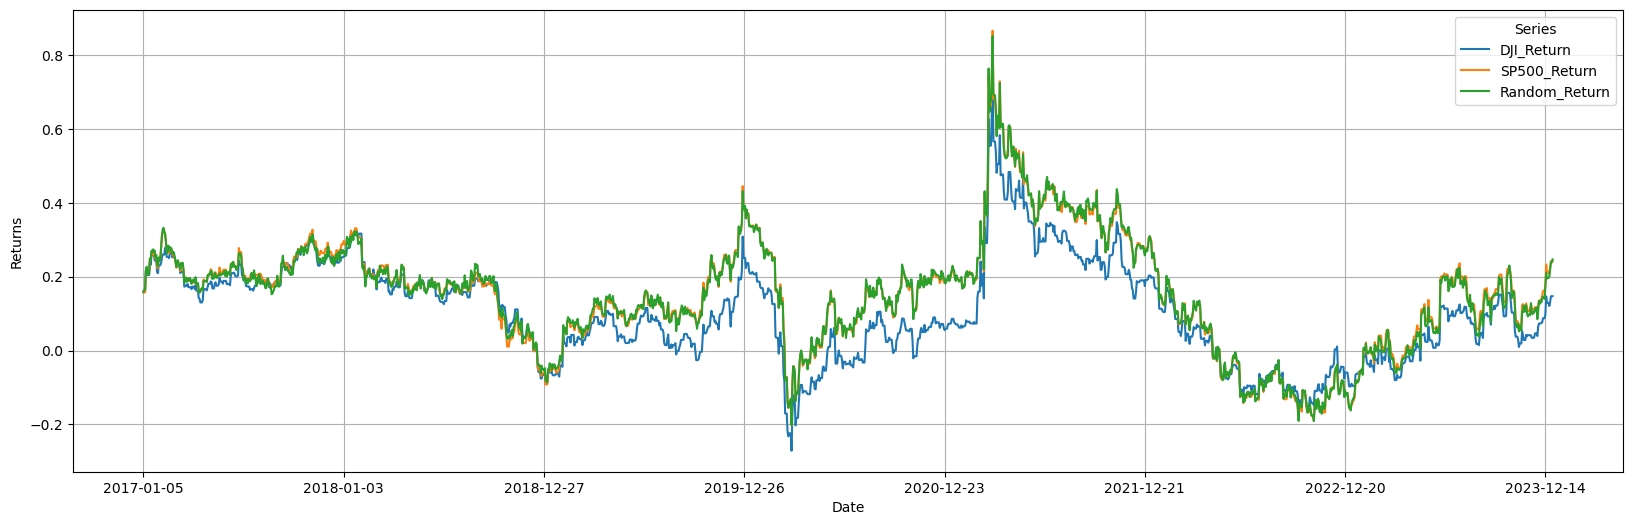

In [327]:
results_kmeans = pd.read_csv('data/baseline_3-1.csv')[['Sell', 'DJI_Return', 'SP500_Return', 'Random_Return']]
results_kmeans.set_index('Sell', inplace=True)

# Create a figure and axis, specifying the size
fig, ax = plt.subplots(figsize=(20, 6))

# Plot the data on the specified axis
results_kmeans.plot(ax=ax)

# Customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
ax.legend(title='Series')
ax.grid(True)

# Show the plot
plt.show()

### 7:1 Method

In [310]:
dates = generate_date_combinations(sp500.prices.index, 7, 1)
dates

,Start,End,Buy,Sell
0,2013-01-02,2020-01-02,2020-01-03,2021-01-04
1,2013-01-03,2020-01-03,2020-01-06,2021-01-06
2,2013-01-04,2020-01-06,2020-01-07,2021-01-07
3,2013-01-07,2020-01-07,2020-01-08,2021-01-08
4,2013-01-08,2020-01-08,2020-01-09,2021-01-11
...,...,...,...,...
748,2015-12-21,2022-12-21,2022-12-22,2023-12-22
749,2015-12-22,2022-12-22,2022-12-23,2023-12-26
750,2015-12-23,2022-12-23,2022-12-27,2023-12-27
751,2015-12-24,2022-12-27,2022-12-28,2023-12-28


In [311]:
results_kmeans = dates.copy()
results_kmeans[['DJI_Sharpe', 'DJI_Sortino', 'DJI_Return']] = results_kmeans.parallel_apply(create_port, args = (None, 'data/dji.csv',), axis = 1)
results_kmeans[['SP500_Sharpe', 'SP500_Sortino', 'SP500_Return']] = results_kmeans.parallel_apply(create_port, args = (None, 'data/sp500_data.csv',), axis = 1)
results_kmeans[['Random_Sharpe', 'Random_Sortino', 'Random_Return']] = results_kmeans.parallel_apply(random_port, args = (30, 100, 'data/sp500_data.csv',), axis = 1)
results_kmeans

,Start,End,Buy,Sell,DJI_Sharpe,DJI_Sortino,DJI_Return,SP500_Sharpe,SP500_Sortino,SP500_Return,Random_Sharpe,Random_Sortino,Random_Return
0,2013-01-02,2020-01-02,2020-01-03,2021-01-04,0.009168,0.010150,0.055492,0.028635,0.030652,0.177011,0.030437,0.033732,0.191068
1,2013-01-03,2020-01-03,2020-01-06,2021-01-06,0.012096,0.013375,0.074069,0.031835,0.034036,0.199243,0.031863,0.035591,0.205803
2,2013-01-04,2020-01-06,2020-01-07,2021-01-07,0.013961,0.015390,0.085974,0.034209,0.036510,0.215735,0.032362,0.035844,0.211476
3,2013-01-07,2020-01-07,2020-01-08,2021-01-08,0.013319,0.014681,0.081853,0.034226,0.036529,0.215854,0.034213,0.037848,0.223197
4,2013-01-08,2020-01-08,2020-01-09,2021-01-11,0.011591,0.012811,0.070857,0.032841,0.035148,0.206262,0.034065,0.037961,0.223103
...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,2015-12-21,2022-12-21,2022-12-22,2023-12-22,0.068261,0.111013,0.131965,0.093912,0.148309,0.225079,0.082214,0.131749,0.223726
749,2015-12-22,2022-12-22,2022-12-23,2023-12-26,0.067694,0.110051,0.130750,0.093920,0.148322,0.225101,0.081427,0.131293,0.222288
750,2015-12-23,2022-12-23,2022-12-27,2023-12-27,0.068684,0.111685,0.132814,0.094707,0.149568,0.227193,0.079864,0.127260,0.217241
751,2015-12-24,2022-12-27,2022-12-28,2023-12-28,0.075951,0.123101,0.147051,0.100681,0.158315,0.242006,0.087006,0.140819,0.236857


In [312]:
results_kmeans.to_csv('data/baseline_7-1.csv')

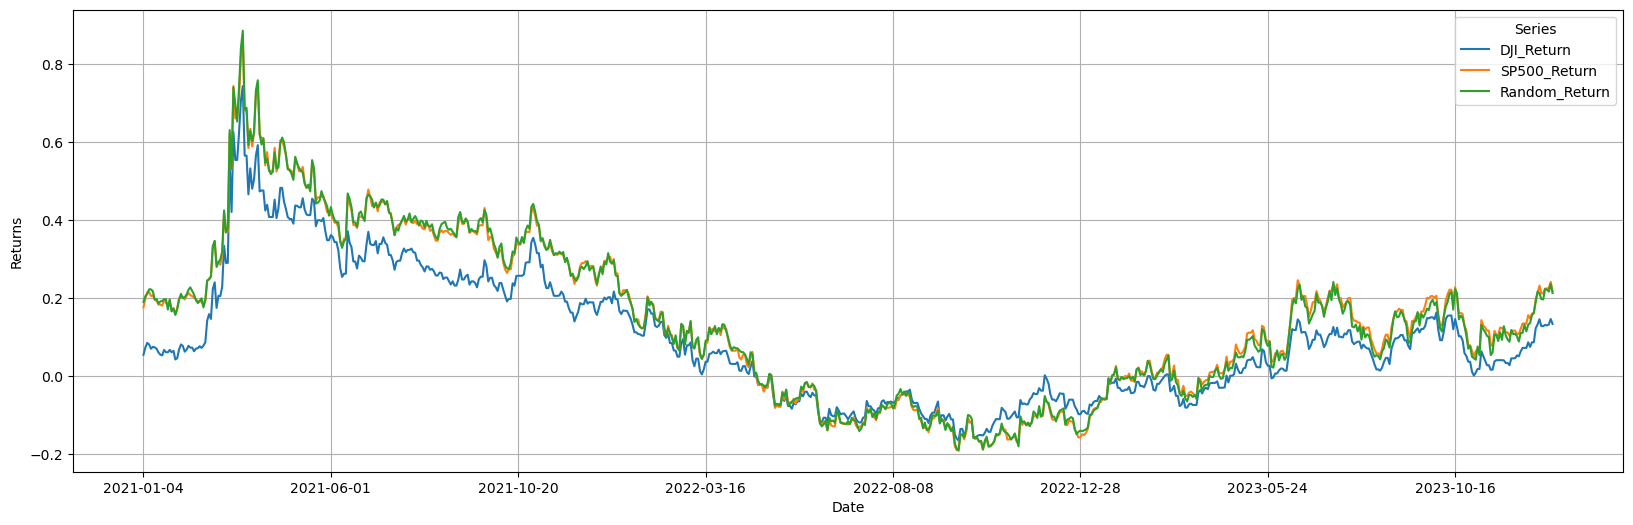

In [328]:
results_kmeans = pd.read_csv('data/baseline_7-1.csv')[['Sell', 'DJI_Return', 'SP500_Return', 'Random_Return']]
results_kmeans.set_index('Sell', inplace=True)

# Create a figure and axis, specifying the size
fig, ax = plt.subplots(figsize=(20, 6))

# Plot the data on the specified axis
results_kmeans.plot(ax=ax)

# Customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
ax.legend(title='Series')
ax.grid(True)

# Show the plot
plt.show()